In [1]:
# 모듈 호출
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

In [2]:
# 생성된 이미지 저장할 폴더
import os
if not os.path.exists("./gan_images"):
    os.makedirs("./gan_images")

In [3]:
# 시드값 고정
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
# 생성자 구성
generator = Sequential()
generator.add(Dense(128*7*7, # 노드개수 128, 이미지 사이즈 7*7
                    input_dim=100, # 입력값의 차원, 임의지정
                    activation=LeakyReLU(0.2))) # relu는 학습이 불안정해지는 경우가 많아 leakyrelu 사용
generator.add(BatchNormalization()) # 입력데이터가 평균0, 분산1이 되도록 > 입력될 값들을 일정하게 재배치
generator.add(Reshape((7,7,128))) # 이미지 사이즈 7*7 > 2번의 업샘플링 후 원본 이미지와 사이즈 동일하도록
generator.add(UpSampling2D())
generator.add(Conv2D(64, # 필터 개수
                     kernel_size=5, # 필터 사이즈 5*5
                     padding='same')) # 패딩 수행, 출력 후에도 사이즈 유지
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2))) # 0아래에서 0이 아니라 0.2를 곱해서 전달함
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=3, padding='same', activation='tanh')) # 활성화함수 tanh 사용(-1~1)

In [5]:
# 판별자 구성 > 기존 CNN의 역할과 차이가 없음 > 진짜/가짜 이진분류
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy',optimizer='adam')
discriminator.trainable=False # 판별자의 학습을 방지

In [7]:
# 모델 구성
ginput = Input(shape=(100,)) # 생성자에서 지정한 차원수
dis_output = discriminator(generator(ginput)) # 생성자로 생성된 데이터를 판별한 결과

gan = Model(ginput, dis_output) # 각각을 입력과 출력으로 가지는 모델 정의
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         864257    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,077,122
Trainable params: 851,585
Non-trainable params: 225,537
_________________________________________________________________


In [8]:
# 실행 함수 정의
def gan_train(epoch, batch_size, saving_interval):
    # 사용할 데이터 불러오기
    (X_train,_),(_,_) = mnist.load_data() # 주어진 라벨 데이터를 이용해 학습하고 분류하는게 아님
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
    X_train = (X_train - 127.5) / 127.5  #  -1~1사이의 값으로 변경
    
    # 이미지 진위 여부에 지정될 라벨
    true = np.ones((batch_size, 1)) 
    fake = np.zeros((batch_size, 1))
    
    for i in range(epoch):
        # 실제 데이터를 판별자에 입력
        idx = np.random.randint(0, X_train.shape[0], batch_size) # 임의로 가져올 이미지의 인덱스
        img = X_train[idx] # 해당 인덱스의 이미지
        d_loss_real = discriminator.train_on_batch(img, true)
        
        # 생성자로 생성된 이미지를 판별자에 입력
        noise = np.random.normal(0,1,(batch_size,100)) # 노이즈 생성
        gen_imgs = generator.predict(noise) # 노이즈로부터 이미지 생성
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        
        d_loss = 0.5*np.add(d_loss_real, d_loss_fake)
        g_loss = gan.train_on_batch(noise, true)
        
        print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)
        
        # 중간 과정 이미지 저장
        if i % saving_interval == 0 :
            noise = np.random.normal(0,1,(25,100))
            gen_imgs = generator.predict(noise)
            
            gen_imgs = 0.5 * gen_imgs + 0.5 # 0~1로 다시 스케일링

            fig, axs = plt.subplots(5, 5)
            count = 0
            for j in range(5):
                for k in range(5):
                    axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                    axs[j, k].axis('off')
                    count += 1
            fig.savefig("gan_images/gan_mnist_%d.png" % i)

epoch:0  d_loss:0.7003  g_loss:0.5094
epoch:1  d_loss:0.4826  g_loss:0.3117
epoch:2  d_loss:0.3963  g_loss:0.1332
epoch:3  d_loss:0.3602  g_loss:0.0555
epoch:4  d_loss:0.3736  g_loss:0.0211
epoch:5  d_loss:0.4319  g_loss:0.0132
epoch:6  d_loss:0.5392  g_loss:0.0252
epoch:7  d_loss:0.6019  g_loss:0.1004
epoch:8  d_loss:0.4902  g_loss:0.5517
epoch:9  d_loss:0.5821  g_loss:0.5936
epoch:10  d_loss:0.5898  g_loss:0.4240
epoch:11  d_loss:0.5062  g_loss:0.3453
epoch:12  d_loss:0.4534  g_loss:0.3540
epoch:13  d_loss:0.3806  g_loss:0.4521
epoch:14  d_loss:0.3332  g_loss:0.6513
epoch:15  d_loss:0.2747  g_loss:0.9629
epoch:16  d_loss:0.2345  g_loss:1.2840
epoch:17  d_loss:0.1930  g_loss:1.4881
epoch:18  d_loss:0.1855  g_loss:1.0801
epoch:19  d_loss:0.1590  g_loss:0.9825
epoch:20  d_loss:0.1642  g_loss:1.0326
epoch:21  d_loss:0.2367  g_loss:1.0608
epoch:22  d_loss:0.1522  g_loss:1.4258
epoch:23  d_loss:0.1863  g_loss:1.0751
epoch:24  d_loss:0.4876  g_loss:0.6226
epoch:25  d_loss:0.6440  g_loss:0.4

epoch:210  d_loss:0.4596  g_loss:2.3692
epoch:211  d_loss:0.3059  g_loss:2.8036
epoch:212  d_loss:0.4486  g_loss:2.4751
epoch:213  d_loss:0.5351  g_loss:2.4600
epoch:214  d_loss:0.4608  g_loss:2.1265
epoch:215  d_loss:0.4836  g_loss:1.9245
epoch:216  d_loss:0.3989  g_loss:1.9291
epoch:217  d_loss:0.4658  g_loss:1.8049
epoch:218  d_loss:0.5008  g_loss:2.1236
epoch:219  d_loss:0.7298  g_loss:1.9176
epoch:220  d_loss:0.4783  g_loss:1.8276
epoch:221  d_loss:0.7220  g_loss:1.4686
epoch:222  d_loss:0.4329  g_loss:1.7934
epoch:223  d_loss:0.5353  g_loss:1.7841
epoch:224  d_loss:0.5696  g_loss:1.8748
epoch:225  d_loss:0.6841  g_loss:1.5683
epoch:226  d_loss:0.6321  g_loss:1.3899
epoch:227  d_loss:0.7075  g_loss:1.0791
epoch:228  d_loss:0.5617  g_loss:1.2830
epoch:229  d_loss:0.6860  g_loss:1.2811
epoch:230  d_loss:0.7525  g_loss:1.1764
epoch:231  d_loss:0.6279  g_loss:1.4157
epoch:232  d_loss:0.6207  g_loss:1.2276
epoch:233  d_loss:0.6078  g_loss:1.2425
epoch:234  d_loss:0.6388  g_loss:1.2789


epoch:416  d_loss:0.4730  g_loss:1.3366
epoch:417  d_loss:0.4064  g_loss:1.5863
epoch:418  d_loss:0.3910  g_loss:2.2918
epoch:419  d_loss:0.4265  g_loss:1.8876
epoch:420  d_loss:0.4241  g_loss:1.9586
epoch:421  d_loss:0.4457  g_loss:1.7213
epoch:422  d_loss:0.4118  g_loss:1.6737
epoch:423  d_loss:0.3621  g_loss:1.6574
epoch:424  d_loss:0.3251  g_loss:1.7734
epoch:425  d_loss:0.2853  g_loss:1.6890
epoch:426  d_loss:0.3318  g_loss:2.0300
epoch:427  d_loss:0.3244  g_loss:2.3118
epoch:428  d_loss:0.3519  g_loss:2.5670
epoch:429  d_loss:0.4035  g_loss:2.1319
epoch:430  d_loss:0.3716  g_loss:1.8769
epoch:431  d_loss:0.3616  g_loss:2.1767
epoch:432  d_loss:0.3669  g_loss:2.5846
epoch:433  d_loss:0.3818  g_loss:2.2138
epoch:434  d_loss:0.3971  g_loss:1.9158
epoch:435  d_loss:0.2855  g_loss:2.1276
epoch:436  d_loss:0.3846  g_loss:1.9382
epoch:437  d_loss:0.3416  g_loss:2.2720
epoch:438  d_loss:0.3079  g_loss:1.9690
epoch:439  d_loss:0.5469  g_loss:1.7260
epoch:440  d_loss:0.3083  g_loss:1.9841


epoch:621  d_loss:0.4215  g_loss:1.6611
epoch:622  d_loss:0.5376  g_loss:1.5659
epoch:623  d_loss:0.4147  g_loss:1.6139
epoch:624  d_loss:0.5221  g_loss:1.5578
epoch:625  d_loss:0.5611  g_loss:1.2695
epoch:626  d_loss:0.5293  g_loss:1.2284
epoch:627  d_loss:0.6016  g_loss:1.4884
epoch:628  d_loss:0.4354  g_loss:1.9321
epoch:629  d_loss:0.5304  g_loss:1.8353
epoch:630  d_loss:0.7404  g_loss:1.7525
epoch:631  d_loss:1.0147  g_loss:1.2004
epoch:632  d_loss:0.9277  g_loss:1.0807
epoch:633  d_loss:0.6379  g_loss:1.6952
epoch:634  d_loss:0.5457  g_loss:1.6894
epoch:635  d_loss:0.7883  g_loss:1.8079
epoch:636  d_loss:0.6015  g_loss:1.7869
epoch:637  d_loss:0.6428  g_loss:1.3845
epoch:638  d_loss:0.5881  g_loss:1.1961
epoch:639  d_loss:0.5293  g_loss:1.4179
epoch:640  d_loss:0.4415  g_loss:1.6752
epoch:641  d_loss:0.6138  g_loss:1.7563
epoch:642  d_loss:0.5751  g_loss:1.9890
epoch:643  d_loss:0.4169  g_loss:2.0340
epoch:644  d_loss:0.3690  g_loss:1.5474
epoch:645  d_loss:0.4670  g_loss:1.5502


epoch:828  d_loss:0.3952  g_loss:2.4186
epoch:829  d_loss:0.3474  g_loss:2.4869
epoch:830  d_loss:0.3261  g_loss:2.3190
epoch:831  d_loss:0.3890  g_loss:2.4780
epoch:832  d_loss:0.3855  g_loss:2.4719
epoch:833  d_loss:0.4297  g_loss:2.5136
epoch:834  d_loss:0.2205  g_loss:2.4761
epoch:835  d_loss:0.3891  g_loss:2.5622
epoch:836  d_loss:0.3232  g_loss:2.2643
epoch:837  d_loss:0.3177  g_loss:2.6116
epoch:838  d_loss:0.2927  g_loss:2.6108
epoch:839  d_loss:0.2492  g_loss:2.8720
epoch:840  d_loss:0.4772  g_loss:2.2017
epoch:841  d_loss:0.3862  g_loss:2.1428
epoch:842  d_loss:0.2086  g_loss:2.3658
epoch:843  d_loss:0.3031  g_loss:2.4394
epoch:844  d_loss:0.3208  g_loss:2.9241
epoch:845  d_loss:0.2636  g_loss:2.8513
epoch:846  d_loss:0.3533  g_loss:1.9813
epoch:847  d_loss:0.2787  g_loss:2.1151
epoch:848  d_loss:0.2546  g_loss:2.3213
epoch:849  d_loss:0.2315  g_loss:2.2571
epoch:850  d_loss:0.2721  g_loss:3.3926
epoch:851  d_loss:0.2693  g_loss:3.1750
epoch:852  d_loss:0.2466  g_loss:2.5620


epoch:1033  d_loss:0.3318  g_loss:2.3740
epoch:1034  d_loss:0.4178  g_loss:1.9610
epoch:1035  d_loss:0.2980  g_loss:1.9020
epoch:1036  d_loss:0.3039  g_loss:1.7002
epoch:1037  d_loss:0.3931  g_loss:2.3198
epoch:1038  d_loss:0.2637  g_loss:2.2076
epoch:1039  d_loss:0.3504  g_loss:2.5365
epoch:1040  d_loss:0.2935  g_loss:2.4394
epoch:1041  d_loss:0.3035  g_loss:2.6058
epoch:1042  d_loss:0.2782  g_loss:2.7453
epoch:1043  d_loss:0.3183  g_loss:2.1732
epoch:1044  d_loss:0.2821  g_loss:2.2352
epoch:1045  d_loss:0.4504  g_loss:2.0947
epoch:1046  d_loss:0.2772  g_loss:2.2599
epoch:1047  d_loss:0.3993  g_loss:2.4570
epoch:1048  d_loss:0.2946  g_loss:2.7271
epoch:1049  d_loss:0.3656  g_loss:2.5670
epoch:1050  d_loss:0.2254  g_loss:2.6770
epoch:1051  d_loss:0.3997  g_loss:2.2042
epoch:1052  d_loss:0.3684  g_loss:2.1485
epoch:1053  d_loss:0.3048  g_loss:2.3674
epoch:1054  d_loss:0.3324  g_loss:2.8552
epoch:1055  d_loss:0.3811  g_loss:2.1167
epoch:1056  d_loss:0.2868  g_loss:1.9692
epoch:1057  d_lo

epoch:1235  d_loss:0.3364  g_loss:2.3200
epoch:1236  d_loss:0.4669  g_loss:2.0262
epoch:1237  d_loss:0.6094  g_loss:1.5604
epoch:1238  d_loss:0.5993  g_loss:1.5274
epoch:1239  d_loss:0.5471  g_loss:1.9200
epoch:1240  d_loss:0.3245  g_loss:2.8480
epoch:1241  d_loss:0.4402  g_loss:2.3604
epoch:1242  d_loss:0.6651  g_loss:2.2797
epoch:1243  d_loss:0.5192  g_loss:1.5836
epoch:1244  d_loss:0.5242  g_loss:1.6667
epoch:1245  d_loss:0.3553  g_loss:2.0006
epoch:1246  d_loss:0.2884  g_loss:1.9883
epoch:1247  d_loss:0.3488  g_loss:2.5564
epoch:1248  d_loss:0.2759  g_loss:2.4566
epoch:1249  d_loss:0.5195  g_loss:2.0776
epoch:1250  d_loss:0.5848  g_loss:1.7478
epoch:1251  d_loss:0.2657  g_loss:1.9293
epoch:1252  d_loss:0.3502  g_loss:1.8565
epoch:1253  d_loss:0.3827  g_loss:2.2312
epoch:1254  d_loss:0.4047  g_loss:2.2892
epoch:1255  d_loss:0.4575  g_loss:2.2204
epoch:1256  d_loss:0.4093  g_loss:2.4441
epoch:1257  d_loss:0.4361  g_loss:2.0938
epoch:1258  d_loss:0.5208  g_loss:2.0049
epoch:1259  d_lo

epoch:1436  d_loss:0.4128  g_loss:1.4582
epoch:1437  d_loss:0.3356  g_loss:2.0557
epoch:1438  d_loss:0.3302  g_loss:2.2333
epoch:1439  d_loss:0.3554  g_loss:2.2321
epoch:1440  d_loss:0.4125  g_loss:1.8170
epoch:1441  d_loss:0.3082  g_loss:2.0728
epoch:1442  d_loss:0.3317  g_loss:1.7492
epoch:1443  d_loss:0.3249  g_loss:1.8316
epoch:1444  d_loss:0.2468  g_loss:2.0994
epoch:1445  d_loss:0.4612  g_loss:1.8993
epoch:1446  d_loss:0.3664  g_loss:1.7277
epoch:1447  d_loss:0.4573  g_loss:1.9032
epoch:1448  d_loss:0.4323  g_loss:1.8210
epoch:1449  d_loss:0.4031  g_loss:1.9295
epoch:1450  d_loss:0.4450  g_loss:1.8340
epoch:1451  d_loss:0.5155  g_loss:1.9783
epoch:1452  d_loss:0.3566  g_loss:1.7817
epoch:1453  d_loss:0.3081  g_loss:1.4209
epoch:1454  d_loss:0.3346  g_loss:1.5676
epoch:1455  d_loss:0.5228  g_loss:1.9370
epoch:1456  d_loss:0.4684  g_loss:1.8568
epoch:1457  d_loss:0.4196  g_loss:2.4190
epoch:1458  d_loss:0.5118  g_loss:1.6331
epoch:1459  d_loss:0.5691  g_loss:1.9632
epoch:1460  d_lo

epoch:1637  d_loss:0.5760  g_loss:1.4950
epoch:1638  d_loss:0.6101  g_loss:1.4718
epoch:1639  d_loss:0.4425  g_loss:1.4023
epoch:1640  d_loss:0.6672  g_loss:1.5896
epoch:1641  d_loss:0.6576  g_loss:1.3121
epoch:1642  d_loss:0.6102  g_loss:1.0920
epoch:1643  d_loss:0.6021  g_loss:1.1279
epoch:1644  d_loss:0.4704  g_loss:1.4717
epoch:1645  d_loss:0.5114  g_loss:1.5155
epoch:1646  d_loss:0.6060  g_loss:1.4028
epoch:1647  d_loss:0.5847  g_loss:1.2713
epoch:1648  d_loss:0.5500  g_loss:1.2754
epoch:1649  d_loss:0.4886  g_loss:1.5207
epoch:1650  d_loss:0.5320  g_loss:1.4653
epoch:1651  d_loss:0.4661  g_loss:1.4437
epoch:1652  d_loss:0.4663  g_loss:1.7774
epoch:1653  d_loss:0.3511  g_loss:1.5930
epoch:1654  d_loss:0.4514  g_loss:1.3533
epoch:1655  d_loss:0.5222  g_loss:1.6249
epoch:1656  d_loss:0.4366  g_loss:1.7729
epoch:1657  d_loss:0.5072  g_loss:1.5198
epoch:1658  d_loss:0.3100  g_loss:1.7342
epoch:1659  d_loss:0.5401  g_loss:1.6208
epoch:1660  d_loss:0.4422  g_loss:1.6663
epoch:1661  d_lo

epoch:1839  d_loss:0.5668  g_loss:1.5378
epoch:1840  d_loss:0.4456  g_loss:1.7445
epoch:1841  d_loss:0.4645  g_loss:1.3814
epoch:1842  d_loss:0.4535  g_loss:1.6388
epoch:1843  d_loss:0.3793  g_loss:2.2986
epoch:1844  d_loss:0.5295  g_loss:1.9085
epoch:1845  d_loss:0.4422  g_loss:1.5324
epoch:1846  d_loss:0.4576  g_loss:1.7073
epoch:1847  d_loss:0.4176  g_loss:1.4111
epoch:1848  d_loss:0.3947  g_loss:1.8469
epoch:1849  d_loss:0.2689  g_loss:2.1502
epoch:1850  d_loss:0.4857  g_loss:2.0586
epoch:1851  d_loss:0.3324  g_loss:1.9873
epoch:1852  d_loss:0.3791  g_loss:1.8370
epoch:1853  d_loss:0.3939  g_loss:1.5890
epoch:1854  d_loss:0.4549  g_loss:2.3752
epoch:1855  d_loss:0.2854  g_loss:2.1949
epoch:1856  d_loss:0.5659  g_loss:1.8946
epoch:1857  d_loss:0.4600  g_loss:1.5124
epoch:1858  d_loss:0.4792  g_loss:1.8430
epoch:1859  d_loss:0.4638  g_loss:1.9527
epoch:1860  d_loss:0.4090  g_loss:1.8255
epoch:1861  d_loss:0.5262  g_loss:1.8861
epoch:1862  d_loss:0.4961  g_loss:1.7871
epoch:1863  d_lo

epoch:2040  d_loss:0.4905  g_loss:1.4536
epoch:2041  d_loss:0.5578  g_loss:1.4084
epoch:2042  d_loss:0.6253  g_loss:1.3383
epoch:2043  d_loss:0.4457  g_loss:1.5370
epoch:2044  d_loss:0.4931  g_loss:1.4260
epoch:2045  d_loss:0.5196  g_loss:1.7628
epoch:2046  d_loss:0.4820  g_loss:1.9539
epoch:2047  d_loss:0.5169  g_loss:1.3809
epoch:2048  d_loss:0.6439  g_loss:1.2441
epoch:2049  d_loss:0.5817  g_loss:1.1625
epoch:2050  d_loss:0.5379  g_loss:1.2242
epoch:2051  d_loss:0.4549  g_loss:1.6413
epoch:2052  d_loss:0.5116  g_loss:1.5113
epoch:2053  d_loss:0.5328  g_loss:1.4206
epoch:2054  d_loss:0.6247  g_loss:1.5969
epoch:2055  d_loss:0.5726  g_loss:1.1946
epoch:2056  d_loss:0.5738  g_loss:1.3541
epoch:2057  d_loss:0.5834  g_loss:1.6363
epoch:2058  d_loss:0.3980  g_loss:1.8079
epoch:2059  d_loss:0.5957  g_loss:1.5146
epoch:2060  d_loss:0.4518  g_loss:1.4846
epoch:2061  d_loss:0.5406  g_loss:1.7403
epoch:2062  d_loss:0.4904  g_loss:1.7174
epoch:2063  d_loss:0.6008  g_loss:1.4413
epoch:2064  d_lo

epoch:2242  d_loss:0.5328  g_loss:1.5779
epoch:2243  d_loss:0.5604  g_loss:1.7540
epoch:2244  d_loss:0.6519  g_loss:1.4057
epoch:2245  d_loss:0.6353  g_loss:1.5979
epoch:2246  d_loss:0.5940  g_loss:1.5781
epoch:2247  d_loss:0.5894  g_loss:1.6825
epoch:2248  d_loss:0.4804  g_loss:1.7982
epoch:2249  d_loss:0.5448  g_loss:1.7718
epoch:2250  d_loss:0.5780  g_loss:1.4432
epoch:2251  d_loss:0.4915  g_loss:1.1648
epoch:2252  d_loss:0.4875  g_loss:1.5495
epoch:2253  d_loss:0.3904  g_loss:1.7503
epoch:2254  d_loss:0.6406  g_loss:1.7681
epoch:2255  d_loss:0.4986  g_loss:1.6938
epoch:2256  d_loss:0.5540  g_loss:1.5315
epoch:2257  d_loss:0.5362  g_loss:1.7206
epoch:2258  d_loss:0.4397  g_loss:1.3756
epoch:2259  d_loss:0.4217  g_loss:1.6668
epoch:2260  d_loss:0.4640  g_loss:1.4257
epoch:2261  d_loss:0.3552  g_loss:1.8862
epoch:2262  d_loss:0.4312  g_loss:1.9419
epoch:2263  d_loss:0.4355  g_loss:1.9270
epoch:2264  d_loss:0.4144  g_loss:1.7685
epoch:2265  d_loss:0.4231  g_loss:1.6881
epoch:2266  d_lo

epoch:2443  d_loss:0.5395  g_loss:1.6188
epoch:2444  d_loss:0.6241  g_loss:1.2735
epoch:2445  d_loss:0.4559  g_loss:1.5157
epoch:2446  d_loss:0.5414  g_loss:1.8167
epoch:2447  d_loss:0.6113  g_loss:1.7061
epoch:2448  d_loss:0.4938  g_loss:1.4947
epoch:2449  d_loss:0.4486  g_loss:1.7939
epoch:2450  d_loss:0.5735  g_loss:1.6233
epoch:2451  d_loss:0.4574  g_loss:1.2676
epoch:2452  d_loss:0.6603  g_loss:1.1876
epoch:2453  d_loss:0.6068  g_loss:1.3519
epoch:2454  d_loss:0.5240  g_loss:1.1968
epoch:2455  d_loss:0.4737  g_loss:1.5207
epoch:2456  d_loss:0.5153  g_loss:1.7432
epoch:2457  d_loss:0.7154  g_loss:1.2562
epoch:2458  d_loss:0.6043  g_loss:1.6085
epoch:2459  d_loss:0.6995  g_loss:0.9313
epoch:2460  d_loss:0.5583  g_loss:1.1264
epoch:2461  d_loss:0.4719  g_loss:1.4261
epoch:2462  d_loss:0.5443  g_loss:1.6736
epoch:2463  d_loss:0.5522  g_loss:1.8702
epoch:2464  d_loss:0.4103  g_loss:1.4047
epoch:2465  d_loss:0.5881  g_loss:1.1219
epoch:2466  d_loss:0.4362  g_loss:1.0940
epoch:2467  d_lo

epoch:2643  d_loss:0.4072  g_loss:1.4362
epoch:2644  d_loss:0.6055  g_loss:1.4322
epoch:2645  d_loss:0.6084  g_loss:1.3669
epoch:2646  d_loss:0.4381  g_loss:1.4486
epoch:2647  d_loss:0.5679  g_loss:1.4451
epoch:2648  d_loss:0.5863  g_loss:1.4233
epoch:2649  d_loss:0.5180  g_loss:1.7093
epoch:2650  d_loss:0.5497  g_loss:1.3985
epoch:2651  d_loss:0.5761  g_loss:1.2369
epoch:2652  d_loss:0.4368  g_loss:1.4683
epoch:2653  d_loss:0.5227  g_loss:1.7568
epoch:2654  d_loss:0.4998  g_loss:1.3611
epoch:2655  d_loss:0.5415  g_loss:1.5941
epoch:2656  d_loss:0.6950  g_loss:1.1762
epoch:2657  d_loss:0.6724  g_loss:1.2721
epoch:2658  d_loss:0.5022  g_loss:1.4159
epoch:2659  d_loss:0.5186  g_loss:1.2369
epoch:2660  d_loss:0.4896  g_loss:1.4775
epoch:2661  d_loss:0.5855  g_loss:1.2214
epoch:2662  d_loss:0.5739  g_loss:1.4484
epoch:2663  d_loss:0.7031  g_loss:1.3684
epoch:2664  d_loss:0.5180  g_loss:1.2992
epoch:2665  d_loss:0.4971  g_loss:1.5844
epoch:2666  d_loss:0.5083  g_loss:1.2993
epoch:2667  d_lo

epoch:2843  d_loss:0.6292  g_loss:1.3268
epoch:2844  d_loss:0.6985  g_loss:1.2120
epoch:2845  d_loss:0.6007  g_loss:1.0206
epoch:2846  d_loss:0.4997  g_loss:1.0967
epoch:2847  d_loss:0.5082  g_loss:1.2658
epoch:2848  d_loss:0.5775  g_loss:1.4383
epoch:2849  d_loss:0.5574  g_loss:1.1873
epoch:2850  d_loss:0.4942  g_loss:1.4035
epoch:2851  d_loss:0.4722  g_loss:1.7750
epoch:2852  d_loss:0.5001  g_loss:1.5483
epoch:2853  d_loss:0.5338  g_loss:1.3865
epoch:2854  d_loss:0.3741  g_loss:1.5654
epoch:2855  d_loss:0.5167  g_loss:1.3892
epoch:2856  d_loss:0.4690  g_loss:1.4424
epoch:2857  d_loss:0.4128  g_loss:1.6440
epoch:2858  d_loss:0.5987  g_loss:1.3001
epoch:2859  d_loss:0.5272  g_loss:1.5427
epoch:2860  d_loss:0.4657  g_loss:1.4203
epoch:2861  d_loss:0.4797  g_loss:1.4937
epoch:2862  d_loss:0.5233  g_loss:1.5710
epoch:2863  d_loss:0.4848  g_loss:1.3584
epoch:2864  d_loss:0.4521  g_loss:1.8595
epoch:2865  d_loss:0.3895  g_loss:1.6792
epoch:2866  d_loss:0.4292  g_loss:1.8311
epoch:2867  d_lo

epoch:3045  d_loss:0.4790  g_loss:1.7102
epoch:3046  d_loss:0.4353  g_loss:1.5133
epoch:3047  d_loss:0.5057  g_loss:1.4642
epoch:3048  d_loss:0.4123  g_loss:1.8082
epoch:3049  d_loss:0.5900  g_loss:1.8158
epoch:3050  d_loss:0.4789  g_loss:1.4045
epoch:3051  d_loss:0.5739  g_loss:1.3914
epoch:3052  d_loss:0.4715  g_loss:1.2027
epoch:3053  d_loss:0.4470  g_loss:1.4021
epoch:3054  d_loss:0.4249  g_loss:1.3951
epoch:3055  d_loss:0.4114  g_loss:1.8282
epoch:3056  d_loss:0.5532  g_loss:1.9887
epoch:3057  d_loss:0.4907  g_loss:1.5825
epoch:3058  d_loss:0.5765  g_loss:1.2825
epoch:3059  d_loss:0.4537  g_loss:1.7088
epoch:3060  d_loss:0.4188  g_loss:1.7439
epoch:3061  d_loss:0.4383  g_loss:1.6644
epoch:3062  d_loss:0.6330  g_loss:1.4165
epoch:3063  d_loss:0.5496  g_loss:1.4727
epoch:3064  d_loss:0.5671  g_loss:1.4779
epoch:3065  d_loss:0.5223  g_loss:1.9830
epoch:3066  d_loss:0.4552  g_loss:2.1574
epoch:3067  d_loss:0.4300  g_loss:2.0885
epoch:3068  d_loss:0.5679  g_loss:1.5432
epoch:3069  d_lo

epoch:3246  d_loss:0.5031  g_loss:1.4412
epoch:3247  d_loss:0.3393  g_loss:1.6832
epoch:3248  d_loss:0.4401  g_loss:1.1974
epoch:3249  d_loss:0.5661  g_loss:1.4551
epoch:3250  d_loss:0.4178  g_loss:1.7772
epoch:3251  d_loss:0.5855  g_loss:1.2224
epoch:3252  d_loss:0.4496  g_loss:1.8400
epoch:3253  d_loss:0.3396  g_loss:1.7127
epoch:3254  d_loss:0.3797  g_loss:1.8174
epoch:3255  d_loss:0.5565  g_loss:1.9018
epoch:3256  d_loss:0.3683  g_loss:1.8677
epoch:3257  d_loss:0.6576  g_loss:1.8829
epoch:3258  d_loss:0.6750  g_loss:1.7685
epoch:3259  d_loss:0.5366  g_loss:1.6430
epoch:3260  d_loss:0.4943  g_loss:1.8339
epoch:3261  d_loss:0.6045  g_loss:1.8878
epoch:3262  d_loss:0.5196  g_loss:1.6677
epoch:3263  d_loss:0.3199  g_loss:1.6120
epoch:3264  d_loss:0.6058  g_loss:1.5420
epoch:3265  d_loss:0.4919  g_loss:1.4809
epoch:3266  d_loss:0.5586  g_loss:1.5964
epoch:3267  d_loss:0.6059  g_loss:1.5166
epoch:3268  d_loss:0.5411  g_loss:1.8728
epoch:3269  d_loss:0.4287  g_loss:1.7900
epoch:3270  d_lo

epoch:3446  d_loss:0.6053  g_loss:1.5799
epoch:3447  d_loss:0.6814  g_loss:1.3031
epoch:3448  d_loss:0.6059  g_loss:1.5345
epoch:3449  d_loss:0.4313  g_loss:1.3246
epoch:3450  d_loss:0.4495  g_loss:1.7579
epoch:3451  d_loss:0.4600  g_loss:2.0495
epoch:3452  d_loss:0.5261  g_loss:1.8491
epoch:3453  d_loss:0.6379  g_loss:1.3561
epoch:3454  d_loss:0.5267  g_loss:1.5350
epoch:3455  d_loss:0.4534  g_loss:1.3478
epoch:3456  d_loss:0.5305  g_loss:1.4864
epoch:3457  d_loss:0.4756  g_loss:1.4053
epoch:3458  d_loss:0.4267  g_loss:1.6522
epoch:3459  d_loss:0.5462  g_loss:1.5072
epoch:3460  d_loss:0.5625  g_loss:1.3870
epoch:3461  d_loss:0.6022  g_loss:1.2629
epoch:3462  d_loss:0.5587  g_loss:1.3006
epoch:3463  d_loss:0.5437  g_loss:1.5164
epoch:3464  d_loss:0.4097  g_loss:1.6647
epoch:3465  d_loss:0.3833  g_loss:1.6665
epoch:3466  d_loss:0.5257  g_loss:1.5703
epoch:3467  d_loss:0.4517  g_loss:1.8088
epoch:3468  d_loss:0.4563  g_loss:1.6811
epoch:3469  d_loss:0.4201  g_loss:1.3886
epoch:3470  d_lo

epoch:3646  d_loss:0.3280  g_loss:1.9740
epoch:3647  d_loss:0.3568  g_loss:2.0503
epoch:3648  d_loss:0.4445  g_loss:1.8616
epoch:3649  d_loss:0.4694  g_loss:1.7425
epoch:3650  d_loss:0.5315  g_loss:1.7675
epoch:3651  d_loss:0.3853  g_loss:1.7979
epoch:3652  d_loss:0.5374  g_loss:1.9207
epoch:3653  d_loss:0.5874  g_loss:1.3874
epoch:3654  d_loss:0.5957  g_loss:1.2266
epoch:3655  d_loss:0.4825  g_loss:1.4848
epoch:3656  d_loss:0.3474  g_loss:2.1010
epoch:3657  d_loss:0.4989  g_loss:1.8800
epoch:3658  d_loss:0.5773  g_loss:1.5414
epoch:3659  d_loss:0.4848  g_loss:1.6934
epoch:3660  d_loss:0.4419  g_loss:1.7779
epoch:3661  d_loss:0.5681  g_loss:1.7450
epoch:3662  d_loss:0.4218  g_loss:1.5236
epoch:3663  d_loss:0.6065  g_loss:1.5736
epoch:3664  d_loss:0.5892  g_loss:1.9945
epoch:3665  d_loss:0.5744  g_loss:1.3260
epoch:3666  d_loss:0.6266  g_loss:1.0004
epoch:3667  d_loss:0.6404  g_loss:1.0996
epoch:3668  d_loss:0.5088  g_loss:1.2563
epoch:3669  d_loss:0.5230  g_loss:1.1743
epoch:3670  d_lo

epoch:3848  d_loss:0.6264  g_loss:1.4373
epoch:3849  d_loss:0.6719  g_loss:1.7354
epoch:3850  d_loss:0.5704  g_loss:1.4008
epoch:3851  d_loss:0.6074  g_loss:1.1819
epoch:3852  d_loss:0.5332  g_loss:0.9292
epoch:3853  d_loss:0.5686  g_loss:1.0890
epoch:3854  d_loss:0.5056  g_loss:1.6043
epoch:3855  d_loss:0.5013  g_loss:1.1690
epoch:3856  d_loss:0.5053  g_loss:1.5004
epoch:3857  d_loss:0.5286  g_loss:1.8450
epoch:3858  d_loss:0.6729  g_loss:1.5730
epoch:3859  d_loss:0.4539  g_loss:1.6721
epoch:3860  d_loss:0.4816  g_loss:1.6219
epoch:3861  d_loss:0.6252  g_loss:1.3925
epoch:3862  d_loss:0.6693  g_loss:1.4476
epoch:3863  d_loss:0.5395  g_loss:1.4088
epoch:3864  d_loss:0.4127  g_loss:1.7885
epoch:3865  d_loss:0.3761  g_loss:1.6889
epoch:3866  d_loss:0.4212  g_loss:2.3853
epoch:3867  d_loss:0.4264  g_loss:2.0657
epoch:3868  d_loss:0.4602  g_loss:1.5996
epoch:3869  d_loss:0.5533  g_loss:1.6228
epoch:3870  d_loss:0.4651  g_loss:1.6191
epoch:3871  d_loss:0.6175  g_loss:1.4714
epoch:3872  d_lo

C:\Users\user\AppData\Local\Temp/ipykernel_21056/1133848824.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(5, 5)


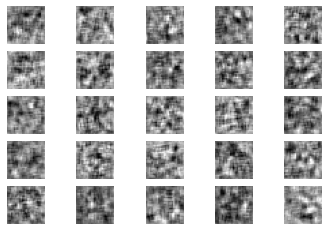

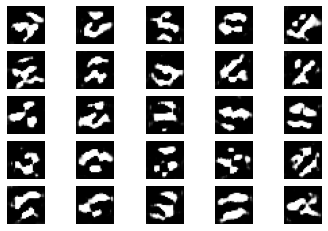

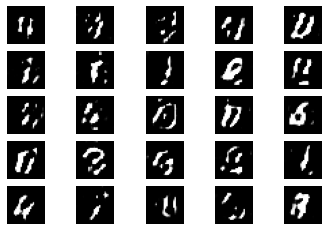

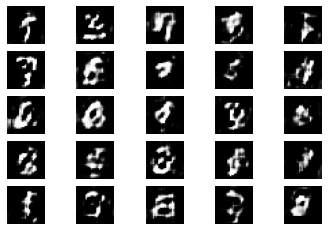

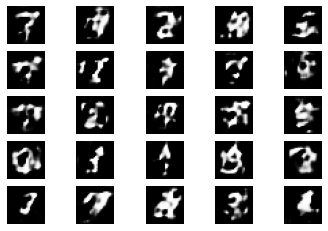

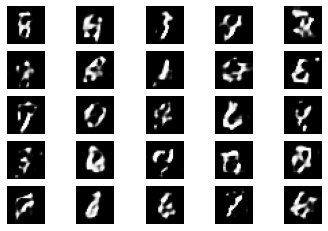

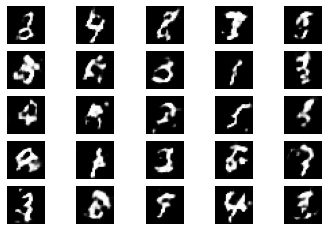

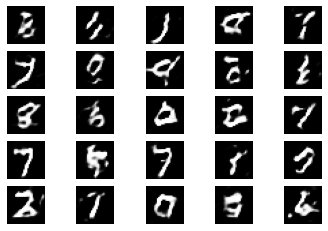

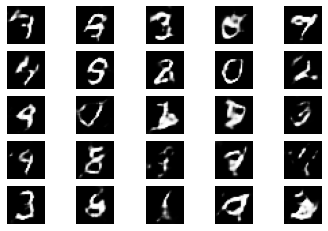

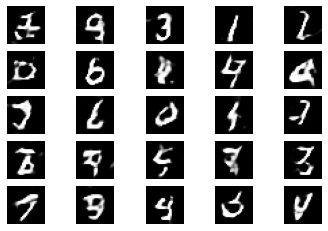

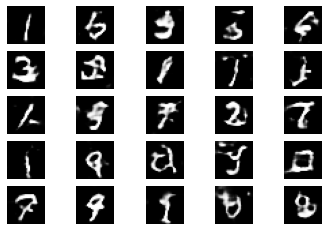

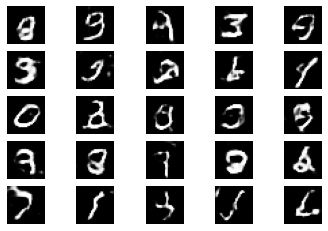

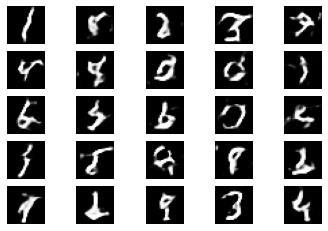

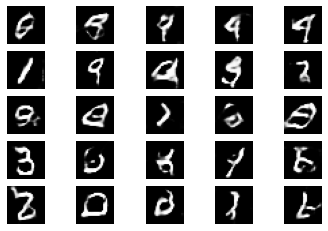

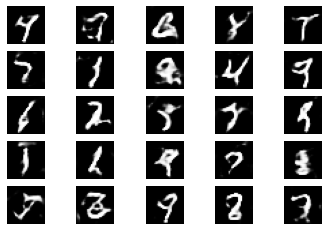

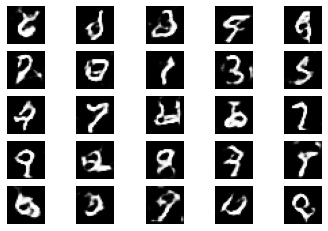

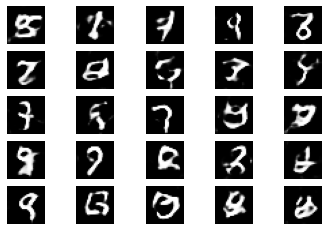

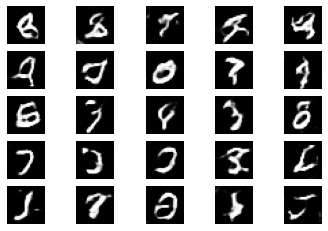

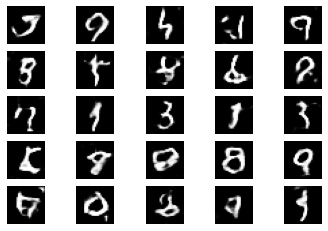

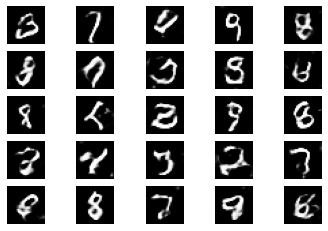

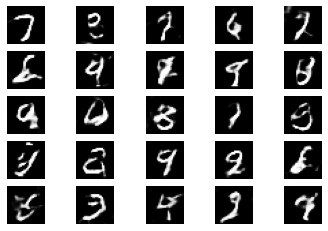

In [9]:
gan_train(4001, 32, 200)  
# 4000번 반복되고(+1 해 주는 것 주의), 배치 사이즈 32,  200번 마다 결과 저장